# In this:
- cách xây dựng và triển khai dịch vụ tìm kiếm neural của chính mình
-> giúp tìm các công ty có mô tả giống với truy vấn đầu vào.
- công ty chứa các thông tin: tên, mô tả, vị trí, hình ảnh

# Workflow

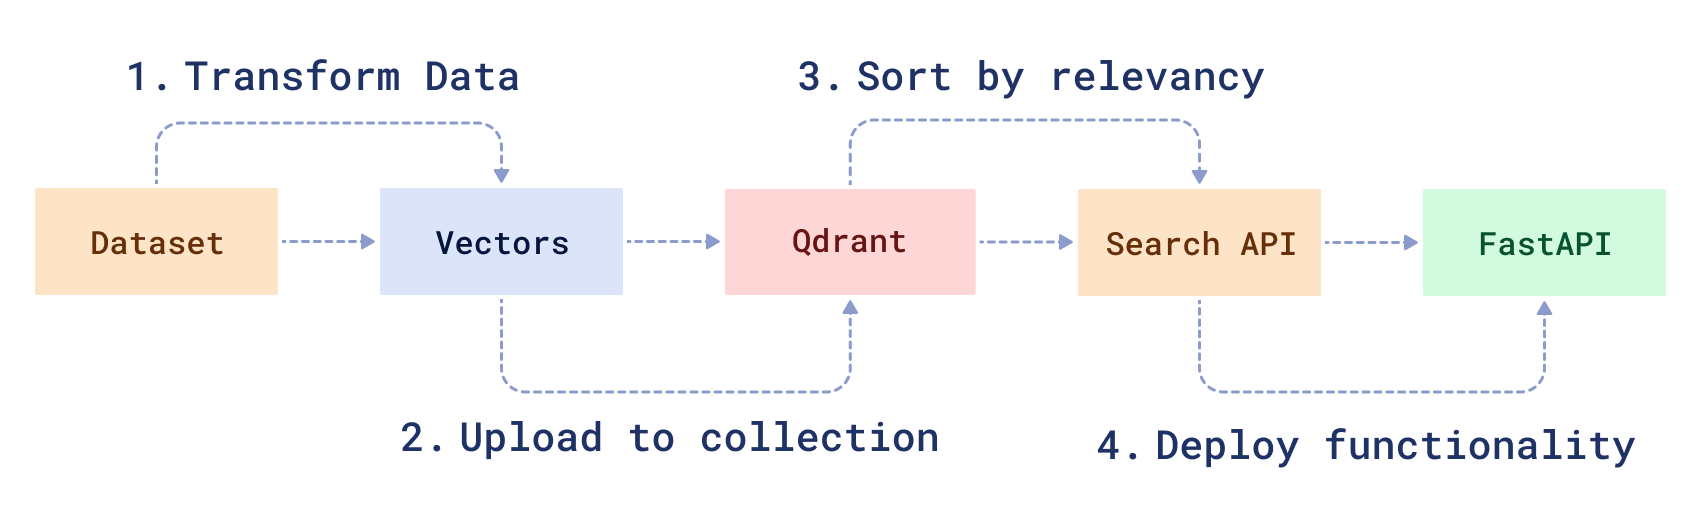

# Prerequisites

To complete this tutorial, you will need:

- Docker - The easiest way to use Qdrant is to run a pre-built Docker image.
- Raw parsed data from startups-list.com.
- Python version >=3.8

# Prepare sample dataset

In [4]:
import json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [5]:
model = SentenceTransformer("..\\embedding_models\\all-MiniLM-L6-v2\\", device="cpu")

In [6]:
df = pd.read_json("..\\datasets\\startup_dataset\\startup_dataset.json", lines=True)

In [8]:
df.head()

,name,images,alt,description,link,city
0,SaferCodes,https://safer.codes/img/brand/logo-icon.png,SaferCodes Logo QR codes generator system form...,QR codes systems for COVID-19.\nSimple tools f...,https://safer.codes,Chicago
1,Human Practice,https://d1qb2nb5cznatu.cloudfront.net/startups...,Human Practice - health care information tech...,Point-of-care word of mouth\nPreferral is a mo...,http://humanpractice.com,Chicago
2,StyleSeek,https://d1qb2nb5cznatu.cloudfront.net/startups...,StyleSeek - e-commerce fashion mass customiza...,Personalized e-commerce for lifestyle products...,http://styleseek.com,Chicago
3,Scout,https://d1qb2nb5cznatu.cloudfront.net/startups...,Scout - security consumer electronics interne...,Hassle-free Home Security\nScout is a self-ins...,http://www.scoutalarm.com,Chicago
4,Invitation codes,https://invitation.codes/img/inv-brand-fb3.png,Invitation App - Share referral codes community,The referral community\nInvitation App is a so...,https://invitation.codes,Chicago


In [10]:
# Mã hóa tất cả các mô tả khởi động để tạo một vectơ nhúng cho từng mô tả. 
# Về mặt nội bộ, hàm mã hóa sẽ chia dữ liệu đầu vào thành nhiều đợt, giúp tăng tốc đáng kể quá trình.
vectors = model.encode(
    [row.alt + ". " + row.description for row in df.itertuples()],
    show_progress_bar=True,
)

vectors.shape

Batches:   0%|          | 0/1265 [00:00<?, ?it/s]

(40474, 384)

In [14]:
# save
np.save("..\\datasets\\startup_dataset\\startup_vectors.npy", vectors, allow_pickle=False)

# Run Qdrant in Docker

In [ ]:
# Next, you need to manage all of your data using a vector engine. Qdrant lets you store, update or delete created vectors. 
# Most importantly, it lets you search for the nearest vectors via a convenient API.

# run this:
# docker pull qdrant/qdrant

# docker run -p 6333:6333 \
#     -v $(pwd)/qdrant_storage:/qdrant/storage \
#     qdrant/qdrant

## Upload data to Qdrant

In [11]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams
from qdrant_client.models import Distance

client = QdrantClient(url="http://localhost:6333")
client.create_collection(
    collection_name="startup",
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),
)

True

In [12]:
if not client.collection_exists("startup"):
    client.create_collection(
        collection_name="startups",
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

In [15]:
fd = open("..\\datasets\\startup_dataset\\startup_dataset.json")

# payload is now an iterator over startup data
payload = map(json.loads, fd)

# Load all vectors into memory, numpy array works as iterable for itself.
# Other option would be to use Mmap, if you don't want to load all data into RAM
vectors = np.load("..\\datasets\\startup_dataset\\startup_vectors.npy")

In [16]:
client.upload_collection(
    collection_name="startup",
    vectors=vectors,
    payload=payload,
    ids=None, # ID vector sẽ được gán tự động
    batch_size=256,  # How many vectors will be uploaded in a single request?
)

## Build the search API

In [ ]:
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer


class NeuralSearcher:
    def __init__(self, collection_name):
        self.collection_name = collection_name
        # Initialize encoder model
        self.model = SentenceTransformer("..\\embedding_models\\all-MiniLM-L6-v2\\", device="cpu")
        # Initialize Qdrant client
        self.qdrant_client = QdrantClient(url="localhost:6333")

    # write the search function
    def search(self, text: str):
        # Convert text query into vector
        vector = self.model.encode(text).tolist()

        # Use "vector" for search for closest vectors in the collection
        search_result = self.qdrant_client.query_points(
            collection_name=self.collection_name,
            query=vector,
            query_filter=None,
            limit=5,
        ).points
        payloads = [hit.payload for hit in search_result]
        return payloads

In [ ]:
# CONTINUE!